# Mettre en place notre environnement
________

La première chose que nous devons faire est de charger les bibliothèques et les ensembles de données que nous allons utiliser. Pour aujourd'hui, nous allons travailler avec deux ensembles de données : un contenant des chroniques de température dans le lit de la rivière (zone hyporhéique), et un autre contenant des les chroniques de différence de charge enregistré en **Volt**.

**Important!** Assurez-vous d'exécuter cette cellule vous-même ou le reste de votre code ne fonctionnera pas

In [56]:
import pathlib
pathlib.Path('BONIN-IMPEROR.ipynb').parent.resolve()

WindowsPath('C:/Users/33681/Documents/2A/MOLONARI/MOLONARI_1D_RESOURCES/Students')

In [57]:
# modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from copy import deepcopy
import matplotlib.gridspec as gs

# read in our data
capteur_riviere = pd.read_csv("C:/Users/33681/Documents/2A/MOLONARI/MOLONARI_1D_RESOURCES/sampling_points/Point034/point034_P_measures.csv")
capteur_ZH = pd.read_csv("C:/Users/33681/Documents/2A/MOLONARI/MOLONARI_1D_RESOURCES/sampling_points/Point034/point034_T_measures.csv")
etalonage_capteur_riv = pd.read_csv("C:/Users/33681/Documents/2A/MOLONARI/MOLONARI_1D_RESOURCES/configuration/pressure_sensors/P508.csv")

# set seed for reproducibility
np.random.seed(0)

Nous sommes maintenant prêts à examiner quelques dates ! (Si vous le souhaitez, vous pouvez profiter de cette occasion pour jeter un coup d'œil à certaines des données).

# Imprimez le noms des colonnes
renommer les colonnes du fichier capteur_riviere :  	dates,tension_V,temperature_stream_C et celles du fichier capteur_ZH  :
#,dates,temperature_depth_1_C,temperature_depth_2_C,temperature_depth_3_C,temperature_depth_4_C



In [58]:
#capteur_riviere.columns
#capteur_riviere.head()
capteur_riviere.columns=['Titre de tracé : point_montberneux', 'dates', 'tension_V','temperature_stream_C', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6']
capteur_riviere=capteur_riviere.drop(columns=['Unnamed: 4','Unnamed: 5','Unnamed: 6'])

In [59]:
#capteur_ZH.columns
capteur_ZH.columns=['#','dates','temperature_depth_1_C','temperature_depth_2_C','temperature_depth_3_C','temperature_depth_4_C','a','b','c']
capteur_ZH=capteur_ZH.drop(columns=['a','b','c'])

# Transformez les données de différence de charge en mètres



In [60]:
#il s'agit de convertir les volts de la colonne tension en mètres, on notera subtilement que ces grandeurs n'étant pas homogènes il y a une formule du cours à utiliser

#voir le fichier info
#on a utilisé le capteur de pression p508, on utilise les coefficients liés à ce capteur
#on a donc l'ordonnée à l'origine et les coordonnées des courbes
dU_dH=-1.462495
dU_dT=0.001474
Intercept=1.210344
#la colonne température du tableau est déjà une différence de température!

$dU=Intercept+ dH\times\frac{dU}{dH}+ dT\times\frac{dU}{dT}$<br>
On inverse la relation : <br>
$dH = \frac{dU - dT\times\frac{dU}{dT} -Intercept }{ \frac{dU}{dH}}$

In [61]:
#on va : rajouter une colonne, lui mettre la formule de calcul dedans
capteur_riviere=capteur_riviere.assign(charge_m=1)
capteur_riviere['tension_V']=pd.to_numeric(capteur_riviere['tension_V'], errors  ='coerce')
capteur_riviere['temperature_stream_C']=pd.to_numeric(capteur_riviere['temperature_stream_C'], errors  ='coerce')
capteur_riviere['charge_m']=(1/dU_dH)*(capteur_riviere['tension_V']-capteur_riviere['temperature_stream_C']*dU_dT-Intercept)

# Traitement des dates
## Vérifiez le type de données de notre colonne de date
___

Imprimer les dates des deux fichiers

In [62]:
capteur_riviere['dates']

0       Date Heure, GMT+01:00
1        06/27/16 12:00:00 PM
2        06/27/16 12:15:00 PM
3        06/27/16 12:30:00 PM
4        06/27/16 12:45:00 PM
                ...          
1456         07/12/2016 15:45
1457         07/12/2016 16:00
1458         07/12/2016 16:15
1459         07/12/2016 16:30
1460         07/12/2016 16:45
Name: dates, Length: 1461, dtype: object

In [63]:
capteur_ZH['dates']

0       06/27/16 12:00:00 PM
1       06/27/16 12:15:00 PM
2       06/27/16 12:30:00 PM
3       06/27/16 12:45:00 PM
4       06/27/16 01:00:00 PM
                ...         
1433    07/12/16 10:15:00 AM
1434    07/12/16 10:30:00 AM
1435    07/12/16 10:45:00 AM
1436    07/12/16 10:49:31 AM
1437    07/12/16 10:49:47 AM
Name: dates, Length: 1438, dtype: object

Remarquez qu'en bas de la sortie de `head()`, vous pouvez voir qu'il est dit que le type de données de cette colonne est "object". 

> Pandas utilise le dtype "object" pour stocker différents types de données, mais le plus souvent, lorsque vous voyez une colonne avec le dtype "object", elle contient des chaînes de caractères. 

Si vous consultez la documentation sur le dtype de Pandas [ici] (http://pandas.pydata.org/pandas-docs/stable/basics.html#dtypes), vous remarquerez qu'il existe également un dtype spécifique `datetime64`. Comme le dtype de notre colonne est `object` plutôt que `datetime64`, nous pouvons dire que Python ne sait pas que cette colonne contient des dates.

Nous pouvons aussi regarder uniquement le dtype de votre colonne sans imprimer les premières lignes si nous le souhaitons :

In [64]:
# check the data type of our date column


In [65]:
print(capteur_ZH.dates.dtype,
capteur_riviere.dates.dtype)

object object


You may have to check the [numpy documentation](https://docs.scipy.org/doc/numpy-1.12.0/reference/generated/numpy.dtype.kind.html#numpy.dtype.kind) to match the letter code to the dtype of the object. "O" is the code for "object", so we can see that these two methods give us the same information.

## Convertir nos colonnes de date en datetime
___

Maintenant que nous savons que notre colonne de date n'est pas reconnue comme une date, il est temps de la convertir pour qu'elle soit reconnue comme une date. Cette opération est appelée "analyse syntaxique des dates" car nous prenons une chaîne de caractères et identifions ses composants. Nous allons utiliser la fonction pd.to_datetime.

Nous pouvons indiquer à pandas le format de nos dates à l'aide d'un guide appelé ["strftime directive", sur lequel vous trouverez plus d'informations à ce lien] (http://strftime.org/). L'idée de base est que vous devez indiquer quelles parties de la date se trouvent où et quelle ponctuation se trouve entre elles. Il existe [de nombreuses parties possibles d'une date](http://strftime.org/), mais les plus courantes sont `%d` pour le jour, `%m` pour le mois, `%y` pour une année à deux chiffres et `%Y` pour une année à quatre chiffres.

Quelques exemples :

 * Le 17 janvier 2007 a le format "%m/%d/%y".
 * 17-1-2007 a le format "%d-%m-%Y".
 

In [66]:
capteur_riviere['dates'] = pd.to_datetime(capteur_riviere['dates'], infer_datetime_format=True, errors='coerce')

Maintenant que nos dates sont analysées correctement, nous pouvons travailler avec celles-ci.

___
* Bien que nous spécifions le format de la date ici, il arrive parfois que vous rencontriez une erreur lorsque plusieurs formats de date sont présents dans une même colonne. Dans ce cas, vous pouvez demander à pandas de déduire le bon format de date. Vous pouvez le faire comme suit :

`capteur_riviere['date'] = pd.to_datetime(capteur_riviere['date'], infer_datetime_format=True)``

**Pourquoi ne pas toujours utiliser `infer_datetime_format = True?`** Il y a deux grandes raisons de ne pas toujours faire deviner à pandas le format de l'heure. La première est que pandas n'est toujours capable de trouver le bon format de date, surtout si quelqu'un a fait preuve de créativité dans la saisie des données. La seconde est que c'est beaucoup plus lent que de spécifier le format exact des dates.
____

In [67]:
capteur_ZH['dates'] = pd.to_datetime(capteur_ZH['dates'], infer_datetime_format=True, errors='coerce')

## Tracer le jour du mois pour vérifier l'analyse de la date
___

L'un des plus grands dangers de l'analyse des dates est de mélanger les mois et les jours. La fonction to_datetime() a des messages d'erreur très utiles, mais il n'est pas inutile de vérifier que les jours du mois que nous avons extraits ont un sens. 

Pour ce faire, nous allons tracer un histogramme des jours du mois. Nous nous attendons à ce qu'il ait des valeurs entre 1 et 31 et, puisqu'il n'y a aucune raison de supposer que les glissements de terrain sont plus fréquents certains jours du mois que d'autres, une distribution relativement égale. (Avec un creux sur 31 car tous les mois n'ont pas 31 jours.) 

array([[<AxesSubplot:title={'center':'jour'}>]], dtype=object)

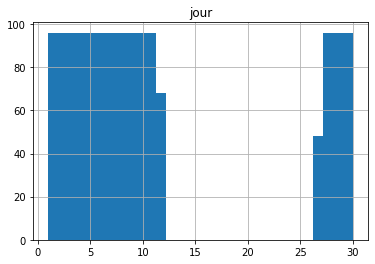

In [68]:
capteur_riviere['jour'] = capteur_riviere['dates'].apply(lambda x: x.day)
capteur_riviere.hist(column = ['jour'],bins=31)
#capteur_riviere.head()

array([[<AxesSubplot:title={'center':'jour'}>]], dtype=object)

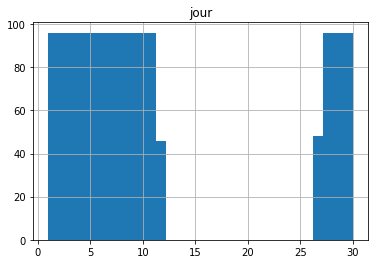

In [69]:
capteur_ZH['jour'] = capteur_ZH['dates'].apply(lambda x: x.day)
capteur_ZH.hist(column = ['jour'],bins=31)
#capteur_ZH.head()

on a pris des mesures du 26 juin au 12 juillet, il est donc normal d'observer un tel creux dans l'histogramme

# Valeurs aberrantes

L'un des plus grands défis du nettoyage des données est l'identification et le traitement des valeurs aberrantes. En termes simples, les valeurs aberrantes sont des observations qui sont significativement différentes des autres points de données. Même les meilleurs algorithmes d'estimation des paramètres automatique seront moins performants si les observations aberrantes ne sont pas nettoyées des données, car elles impliquent des simulations obsolètes des variables.



Nous mettons ici plusieurs fonctions et cellules à éxécuter afin de pouvoir appliquer le tri par écart  interquartile et par score Z.

In [71]:
liste_titre_riviere=['tension_V','temperature_stream_C','charge_m']
liste_titre_ZH=['temperature_depth_1_C','temperature_depth_2_C','temperature_depth_3_C','temperature_depth_4_C']

In [72]:
def affiche_moustache():#capteur_riviere.boxplot(['tension_V'])#on peut tracer ainsi toutes les boites pour les deux tableaux
    fig,ax
    plt.title('Diagramme à moustaches des données étudiées')
    a=245
    b=241
    for name in liste_titre_riviere :
        plt.subplot(a)
        a+=1
        capteur_riviere.boxplot([name])
    for name in liste_titre_ZH :
        plt.subplot(b)
        b+=1
        capteur_ZH.boxplot([name])
    plt.show()


In [74]:
def affiche_scatterplot():#affichage des liens entre les différentes variables de température
    for i in range(1,4):
        for j in range(i+1,5):
            plt.subplot(3,3,3*(j-2)+i)
            plt.title(f'{i},{j}')
            plt.scatter(capteur_ZH[f'temperature_depth_{i}_C'],capteur_ZH[f'temperature_depth_{j}_C'])


In [106]:
def affiche_tout(capteur_riviere,capteur_ZH):

    fig = plt.figure(figsize=(30,6))
    grid = gs.GridSpec(3, 8,height_ratios=[3,1,1]) 
    for i, g in enumerate(liste_titre_riviere+liste_titre_ZH):
        if i<3:
            subset = capteur_riviere[g]
        else:
            subset = capteur_ZH[g]
    
        # Histogram
        ax = fig.add_subplot(grid[:2,i])
        ax.hist(list(subset), color='k', alpha=0.4)
        ax.set_title("Statistiques de "+g)
    
        # Box plot
        ax2 = fig.add_subplot(grid[2,i])
        pd.DataFrame(subset).boxplot(vert=False, return_type='axes')
        ax2.set_yticklabels([''])

    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    fig.suptitle(f'Affichage des statistiques', fontsize=20)

    None # Don't display the last thing -- `%matplotlib inline` will display the graphs no matter what.


## Tracez les graphiques de distribution pour les différentes variables

Nous avons supprimé les cellules explicatives par souci d'esthétique du Notebook, les différents types de graphique seront utilisés pour la comparaison des méthodes.

## Identification des valeurs aberrantes avec l'écart interquartile (IQR)

L'écart interquartile (IQR) est une mesure de la dispersion statistique et est calculé comme la différence entre les 75e et 25e percentiles. Il est représenté par la formule IQR = Q3 - Q1. Les  lignes de code ci-dessous calculent et impriment l'écart interquartile pour chacune des variables de l'ensemble de données.  La règle générale est que tout ce qui n'est pas dans la plage de (Q1 - 1,5 IQR) et (Q3 + 1,5 IQR) est une valeur aberrante et peut être supprimé.


In [21]:
#ces deux tris suppriment du tableau les valeurs hors de la plage Q1-1.5*IQR, Q3+1.5*IQR
def tri_IQR_riviere(capteur_riviere):
    new_capteur_riviere=deepcopy(capteur_riviere)
    stats_riviere=new_capteur_riviere.describe()
    n,p_riviere=stats_riviere.shape
    IQR=[]
    Vmin=[]
    Vmax=[]
    for i in range(p_riviere):
        q1=stats_riviere.iloc[4,i]#q1 sur ligne 4
        q3=stats_riviere.iloc[6,i]#q3 sur ligne 6
        IQR.append(q3-q1)
        Vmin.append(q1-1.5*IQR[i])
        Vmax.append(q3+1.5*IQR[i])
        
    for (indice,colname) in enumerate(new_capteur_riviere):
        if (indice>1 and (indice != p_riviere-1)) :#car les deux premières colonnes de capteur_riviere ne sont pas des floats, et on ne veut pas filtrer selon les jours
            vmin,vmax=Vmin[indice-2],Vmax[indice-2]
    
            indexNames = new_capteur_riviere[new_capteur_riviere[colname] > vmax].index
            new_capteur_riviere.drop(indexNames,inplace=True)
            indexNames = new_capteur_riviere[new_capteur_riviere[colname] < vmin].index
            new_capteur_riviere.drop(indexNames,inplace=True)

    return new_capteur_riviere
  
def tri_IQR_riviere_inplace(capteur_riviere):
    stats_riviere=capteur_riviere.describe()
    n,p_riviere=stats_riviere.shape
    IQR=[]
    Vmin=[]
    Vmax=[]
    for i in range(p_riviere):
        q1=stats_riviere.iloc[4,i]#q1 sur ligne 4
        q3=stats_riviere.iloc[6,i]#q3 sur ligne 6
        IQR.append(q3-q1)
        Vmin.append(q1-1.5*IQR[i])
        Vmax.append(q3+1.5*IQR[i])
        
    for (indice,colname) in enumerate(capteur_riviere):
        if (indice>1 and (indice != p_riviere-1)) :#car les deux premières colonnes de capteur_riviere ne sont pas des floats, et on ne veut pas filtrer selon les jours
            vmin,vmax=Vmin[indice-2],Vmax[indice-2]
    
            indexNames = capteur_riviere[capteur_riviere[colname] > vmax].index
            capteur_riviere.drop(indexNames,inplace=True)
            indexNames = capteur_riviere[capteur_riviere[colname] < vmin].index
            capteur_riviere.drop(indexNames,inplace=True)


In [22]:
def tri_IQR_ZH_inplace(capteur_ZH):
    stats_ZH=capteur_ZH.describe()
    n,p_ZH=stats_ZH.shape
    IQR_ZH=[]
    Vmin_ZH=[]
    Vmax_ZH=[]
    for i in range(p_ZH):
        q1=stats_ZH.iloc[4,i]
        q3=stats_ZH.iloc[6,i]
        IQR_ZH.append(q3-q1)
        Vmin_ZH.append(q1-1.5*IQR_ZH[i])
        Vmax_ZH.append(q3+1.5*IQR_ZH[i])

    for (indice,colname) in enumerate(capteur_ZH):
        if (indice>1 and (indice != p_ZH)) :#car les deux premières colonnes de capteur_ZH ne sont pas des floats, et on ne veut pas filtrer selon les jours
            vmin,vmax=Vmin_ZH[indice-1],Vmax_ZH[indice-1]
       
            indexNames = capteur_ZH[capteur_ZH[colname] > vmax].index
            capteur_ZH.drop(indexNames,inplace=True)
            indexNames = capteur_ZH[capteur_ZH[colname] < vmin].index
            capteur_ZH.drop(indexNames,inplace=True)
            
def tri_IQR_ZH(capteur_ZH):
    new_capteur_ZH=deepcopy(capteur_ZH)
    stats_ZH=new_capteur_ZH.describe()
    n,p_ZH=stats_ZH.shape
    IQR_ZH=[]
    Vmin_ZH=[]
    Vmax_ZH=[]
    for i in range(p_ZH):
        q1=stats_ZH.iloc[4,i]
        q3=stats_ZH.iloc[6,i]
        IQR_ZH.append(q3-q1)
        Vmin_ZH.append(q1-1.5*IQR_ZH[i])
        Vmax_ZH.append(q3+1.5*IQR_ZH[i])

    for (indice,colname) in enumerate(new_capteur_ZH):
        if (indice>1 and (indice != p_ZH)) :#car les deux premières colonnes de capteur_ZH ne sont pas des floats, et on ne veut pas filtrer selon les jours
            vmin,vmax=Vmin_ZH[indice-1],Vmax_ZH[indice-1]
       
            indexNames = new_capteur_ZH[new_capteur_ZH[colname] > vmax].index
            new_capteur_ZH.drop(indexNames,inplace=True)
            indexNames = new_capteur_ZH[new_capteur_ZH[colname] < vmin].index
            new_capteur_ZH.drop(indexNames,inplace=True)

    return new_capteur_ZH

## Valeurs abérantes avec la méthode score Z 
Il s'agit d'une unité mesurée en écart-type. Fondamentalement, il s'agit d'une mesure de la distance entre le score brut et la moyenne. Il est compris entre -3 et +3, où 0 = moyenne et 1 = écart-type, c'est-à-dire une distribution normale.

Cette méthode suggère qu'en tout point de données il existe une relation entre l'écart-type et la moyenne. Le score Z permet de trouver la distribution des données où la moyenne est égale à 0 et l'écart-type à 1, c'est-à-dire une distribution normale. Vous devez vous demander en quoi cela peut nous aider à identifier les valeurs aberrantes ? En calculant le score Z, nous redimensionnons et centrons les données et recherchons les points de données qui sont trop éloignés de zéro. Ces points de données qui sont trop éloignés de zéro seront traités comme des valeurs aberrantes. Dans la plupart des cas, un seuil de 3 ou -3 est utilisé, c'est-à-dire que si la valeur du score Z est supérieure ou inférieure à 3 ou -3 respectivement, ce point de données sera identifié comme aberrant.

Formule pour le score Z = (Observation - Moyenne)/Écart-type

z = (X - μ) / σ

Ecrire des functions afin de pouvoir appliquer cette méthodologie aux données

In [111]:
#ces deux fonctions suppriment du tableau les données pour lesquelles la valeur du score Z n'est pas comprise entre -3 et 3

def tri_score_Z_riviere_inplace(capteur_riviere):
    stats_riviere=capteur_riviere.describe()
    n,p_riviere=stats_riviere.shape
    Mean_riviere=[]
    Std_riviere=[]
    for i in range(p_riviere-1):#jour ne nous intéresse pas
        Mean_riviere.append(stats_riviere.iloc[1,i])#q1 sur ligne 4
        Std_riviere.append(stats_riviere.iloc[2,i])#q3 sur ligne 6

    for (indice,colname) in enumerate(capteur_riviere):
        if indice>=2 and indice<5: #on ne traite que les colonnes 2, 3 et 4
            capteur_riviere['score_Z_'+colname]=((1/Std_riviere[indice-2])*(capteur_riviere[colname]-Mean_riviere[indice-2]))
            indexNames = capteur_riviere[capteur_riviere['score_Z_'+colname]>3].index
            capteur_riviere.drop(indexNames,inplace=True)
            indexNames = capteur_riviere[capteur_riviere['score_Z_'+colname]<-3].index
            capteur_riviere.drop(indexNames,inplace=True)

def tri_score_Z_ZH_inplace(capteur_ZH):
    stats_ZH=capteur_ZH.describe()
    n,p_ZH=stats_ZH.shape
    Mean_ZH=[]
    Std_ZH=[]
    for i in range(1,p_ZH-1):#car premiere colonne et derniere colonne ne nous interessent pas
        Mean_ZH.append(stats_ZH.iloc[1,i])
        Std_ZH.append(stats_ZH.iloc[2,i]) 

            
    for (indice,colname) in enumerate(capteur_ZH):
        if indice>=2 and indice<6 :#car les deux premières colonnes de capteur_ZH ne sont pas des floats, et on ne veut pas filtrer selon les jours
            capteur_ZH['score_Z_'+colname]=(1/Std_ZH[indice-2])*(capteur_ZH[colname]-Mean_ZH[indice-2])
            indexNames = capteur_ZH[capteur_ZH['score_Z_'+colname]>3].index
            capteur_ZH.drop(indexNames,inplace=True)
            indexNames = capteur_ZH[capteur_ZH['score_Z_'+colname]<-3].index
            capteur_ZH.drop(indexNames,inplace=True)
            

def tri_score_Z_riviere(capteur_riviere):
    new_capteur_riviere=deepcopy(capteur_riviere)
    stats_riviere=new_capteur_riviere.describe()
    n,p_riviere=stats_riviere.shape
    Mean_riviere=[]
    Std_riviere=[]
    for i in range(p_riviere-1):#jour ne nous intéresse pas
        Mean_riviere.append(stats_riviere.iloc[1,i])#q1 sur ligne 4
        Std_riviere.append(stats_riviere.iloc[2,i])#q3 sur ligne 6

    for (indice,colname) in enumerate(new_capteur_riviere):
        if indice>=2 and indice<5: #on ne traite que les colonnes 2, 3 et 4
            new_capteur_riviere['score_Z_'+colname]=((1/Std_riviere[indice-2])*(new_capteur_riviere[colname]-Mean_riviere[indice-2]))
            indexNames = new_capteur_riviere[new_capteur_riviere['score_Z_'+colname]>3].index
            new_capteur_riviere.drop(indexNames,inplace=True)
            indexNames = new_capteur_riviere[new_capteur_riviere['score_Z_'+colname]<-3].index
            new_capteur_riviere.drop(indexNames,inplace=True)
            
    return new_capteur_riviere

def tri_score_Z_ZH(capteur_ZH):
    new_capteur_ZH=deepcopy(capteur_ZH)
    stats_ZH=new_capteur_ZH.describe()
    n,p_ZH=stats_ZH.shape
    Mean_ZH=[]
    Std_ZH=[]
    for i in range(1,p_ZH-1):#car premiere colonne et derniere colonne ne nous interessent pas
        Mean_ZH.append(stats_ZH.iloc[1,i])
        Std_ZH.append(stats_ZH.iloc[2,i]) 

            
    for (indice,colname) in enumerate(new_capteur_ZH):
        if indice>=2 and indice<6 :#car les deux premières colonnes de capteur_ZH ne sont pas des floats, et on ne veut pas filtrer selon les jours
            new_capteur_ZH['score_Z_'+colname]=(1/Std_ZH[indice-2])*(new_capteur_ZH[colname]-Mean_ZH[indice-2])
            indexNames = new_capteur_ZH[new_capteur_ZH['score_Z_'+colname]>3].index
            new_capteur_ZH.drop(indexNames,inplace=True)
            indexNames = new_capteur_ZH[new_capteur_ZH['score_Z_'+colname]<-3].index
            new_capteur_ZH.drop(indexNames,inplace=True)
            
    return new_capteur_ZH


## Comparer les deux méthodologies, donner leurs avantages et leurs limitations
Vous pouvez proposer des alternatives.

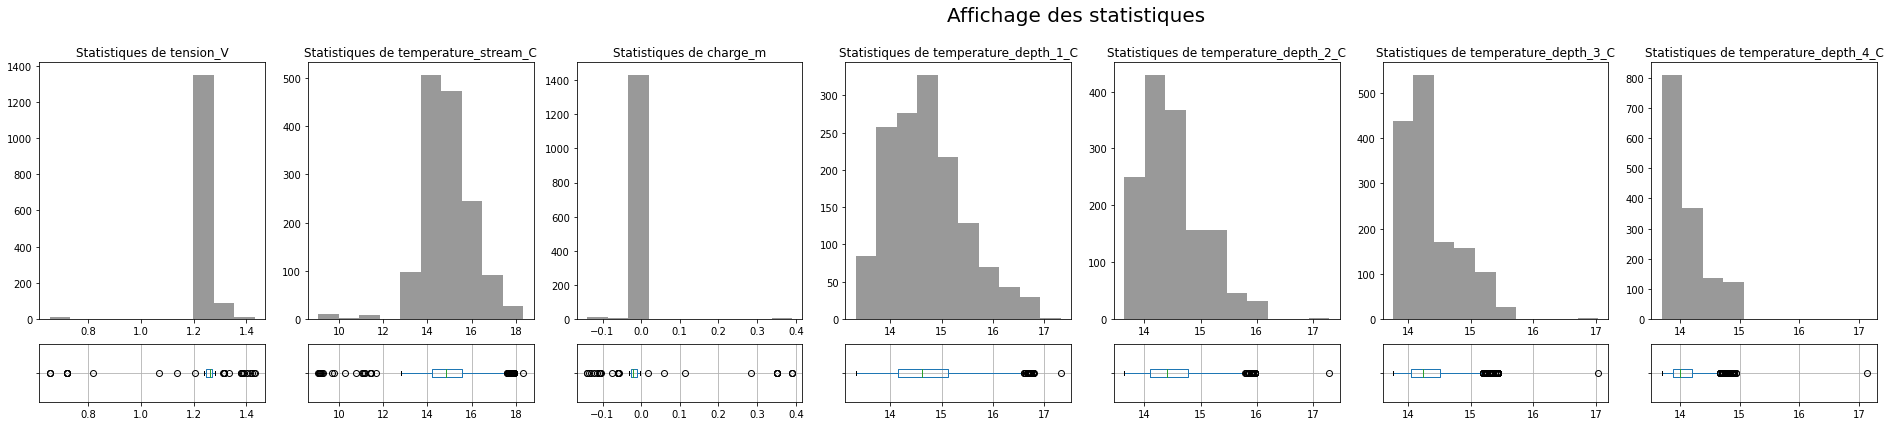

In [112]:
affiche_tout(capteur_riviere,capteur_ZH)

In [113]:
capteur_riviere_IQR=tri_IQR_riviere(capteur_riviere)
capteur_ZH_IQR=tri_IQR_ZH(capteur_ZH)
capteur_riviere_Z=tri_score_Z_riviere(capteur_riviere)
capteur_ZH_Z=tri_score_Z_ZH(capteur_ZH)

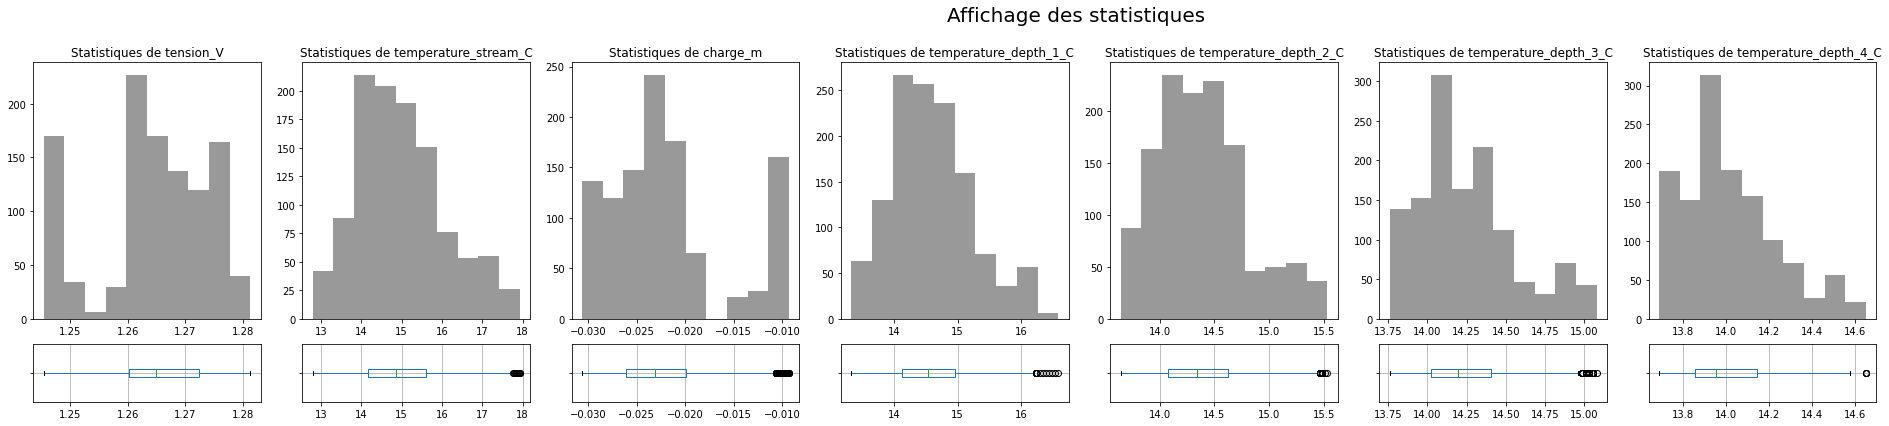

In [114]:
affiche_tout(capteur_riviere_IQR,capteur_ZH_IQR)

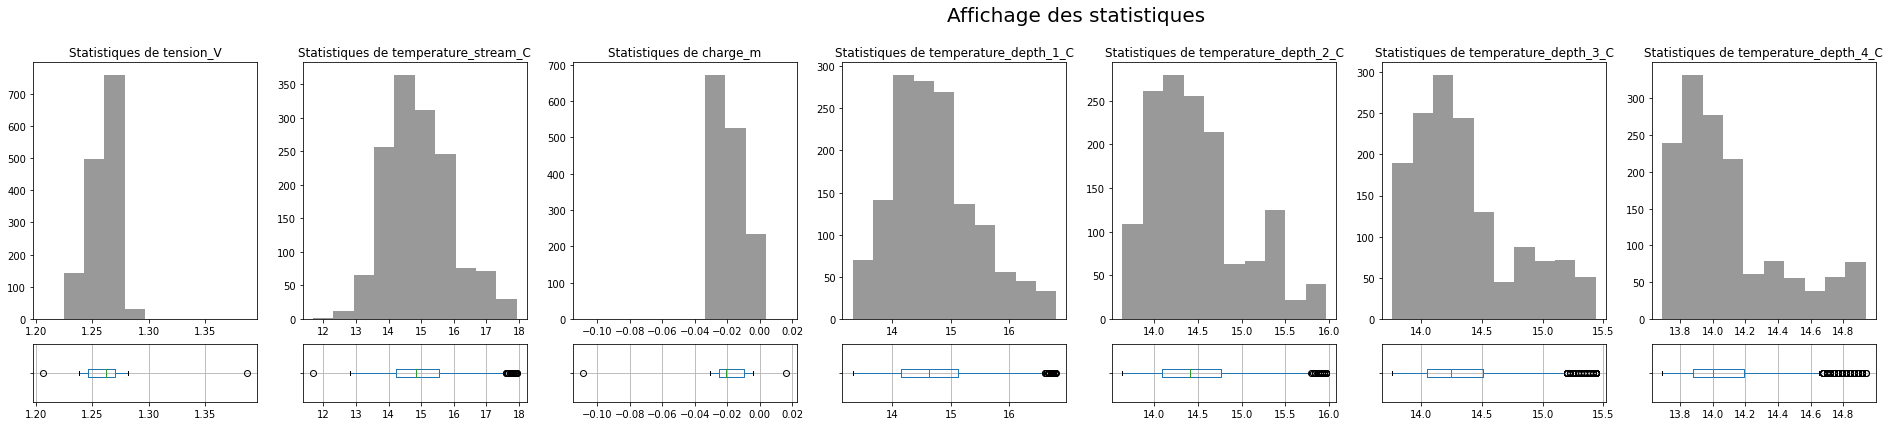

In [115]:
affiche_tout(capteur_riviere_Z,capteur_ZH_Z)

Commentaire sur les résultats. Sur les valeurs de départ, on observe sur les histogrammes que la tension présente des valeurs aberrantes car un seul pic et des tous petits à côté. Ce phénomène disparaît après un tri, que ce soit le tri par score Z ou bien par écart intequartile. Dans l'ensemble les tris semblent être à peu près similaire. Cependant, on observe des différences importantes, principalement sur la tension (et la charge mais celle-ci découle d'un calcul venant de la tension). Sur le diagramme en moustache de la tension après tri par score Z on observe que celui-ci a gardé des valeurs en dehors des traits de bout, qu'on pourrait qualifier d'extrêmes. Cela est confirmé par l'histogramme de la tension après tri par score Z qui est encore très écrasé.
Pour les variables de température, ces deux tris ont l'air à chaque fois d'obtenir des résultats similaires avec une présence de valeurs de températures plus élevées qui restent à chaque fois ; peut-être ne faut-il pas les considérer comme aberrantes mais comme témoin d'un phénomène physique, un épisode de canicule par exemple?
Enfin, sur la température de stream (rivière), on retrouve ce même amas de valeurs élevées, peut-être donc caractéristique d'un même phénomène météorologique extrême. De nouveau, le tri par écart interquartile semble être à favoriser.

En toute sincérité, nous ne voyons pas les avantages du tri par score Z qui pourtant nous paraît bien programmé. Les données de base ont en fait presque toutes un score Z déjà compris entre -3 et 3.

## Proposer une fonction permettant d'aller des données brutes jusqu'au premier traitement des données.

N'oubliez pas de permettre à l'utilisateur de pouvoir prendre des décisions et de l'aider à prendre ces décisions
Pensez à indiquer à l'utilisateur si le jeu de données est utilisable, quels sont les capteurs défaillant, quel semble être l'orientation des échanges nappe-rivière, les données de différence de charge semblent t'elles données les mêmes informations que les données du profils de température.

Votre function doit prendre en entrée, les trois fichiers et proposer au fur et à mesure de son dérouler des propositions à l'utilisateur.

Afin de déterminer une méthodologie nous allons observer ce que nous donne les résultats obtenus après tri successifs.

# Deux autres jeux de données sont disponibles sur le répertoire github.
Votre rôle est de traiter et d'analyser ces données avec la méthodologie que vous avez développé